In [0]:
import pandas as pd
import pyspark
from pyspark.sql.functions import split,explode,col,substring,to_date
import matplotlib.pyplot as plt

ALL FUNCTIONS USED

In [0]:
def load(filepath, delimiter):
    df = spark.read.csv(filepath, header = True, inferSchema = True, sep = delimiter)
    return df

In [0]:
def group_order(data,column):
    return data.groupBy(column).count().orderBy("count", ascending = False)

LOADING DATA FROM CSV FILES

In [0]:
df =  load("/FileStore/tables/clinicaltrial_2021.csv/", '|')
meshdf = load("/FileStore/tables/mesh.csv/", ",")
pharmadf = load("/FileStore/tables/pharma.csv/", ",")

IMPLEMENTATION OF QUESTION 1

In [0]:
df.distinct().count()

Out[5]: 387261

IMPLEMENTATION OF QUESTION 2

In [0]:
group_order(df,'Type').show()

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



IMPLEMENTATION OF QUEST 3

In [0]:
explodeddf1=df.withColumn("conditions", explode(split(df["conditions"], ',')))
group_order(explodeddf1, "conditions").show(5)

+-----------------+-----+
|       conditions|count|
+-----------------+-----+
|        Carcinoma|13389|
|Diabetes Mellitus|11080|
|        Neoplasms| 9371|
| Breast Neoplasms| 8640|
|         Syndrome| 8032|
+-----------------+-----+
only showing top 5 rows



IMPLEMENTATION OF QUESTION 4

In [0]:
mesh_exploded= meshdf.withColumn("term", explode(split(meshdf["term"], ',')))
mes = meshdf.select("term", substring("tree", 0,3).alias("codes"))

In [0]:
condf1 = explodeddf1.select("Conditions")
joineddf1 = condf1.join(mes, condf1.Conditions == mes.term)
group_order(joineddf1, "Codes").show(10)

+-----+------+
|Codes| count|
+-----+------+
|  C04|143994|
|  C23|136079|
|  C01|106674|
|  C14| 94523|
|  C10| 92310|
|  C06| 85646|
|  C08| 70720|
|  C13| 42599|
|  C18| 41276|
|  C12| 40161|
+-----+------+
only showing top 10 rows



IMPLEMENTATION OF QUESTION 5

In [0]:
p1df = pharmadf.select("Parent_Company")
sponsordf = df.select("Sponsor")
joindf21 = sponsordf.join(p1df, sponsordf.Sponsor == p1df.Parent_Company, 'leftanti')
group_order(joindf21,"Sponsor").show(10)

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+
only showing top 10 rows



IMPLEMENTATION FOR QUESTION 6

In [0]:
completiondf21 = df.select("Status", substring("Completion", 0,3).alias('month'), \
                        substring("Completion", 5,4).alias('year'))
completed_df = completiondf21[(completiondf21.year == 2021) & (completiondf21.Status == "Completed")]
q6_result = completed_df.where(completed_df.month != ' ').groupBy("month").count().orderBy(to_date(col("month"),"MMM"))
display(q6_result)

month,count
Jan,1131
Feb,934
Mar,1227
Apr,967
May,984
Jun,1094
Jul,819
Aug,700
Sep,528
Oct,187


VISUALISATION FOR QUESTION 6

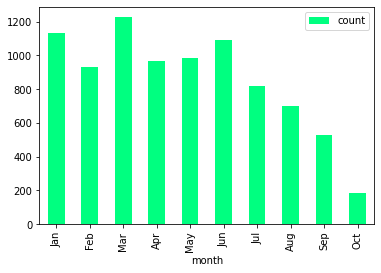

In [0]:
q6_result.toPandas().plot(kind = "bar", x="month", y="count", colormap="winter_r")
plt.show()

FURTHER ANALYSIS COUNTRIES AND NO.OF STUDIES THEY ARE SPONSORING

In [0]:
q7 =pharmadf.select("Parent_Company","HQ_Country_of_Parent","Offense_Group")
q7 = sponsordf.join(q7, sponsordf.Sponsor==q7.Parent_Company)

In [0]:
q7_result = group_order(q7,"HQ_Country_of_Parent")
display(q7_result)

HQ_Country_of_Parent,count
USA,276785
United Kingdom,182823
France,35672
Germany,27538
Switzerland,26910
Israel,4240
Ireland,1842
Australia,30


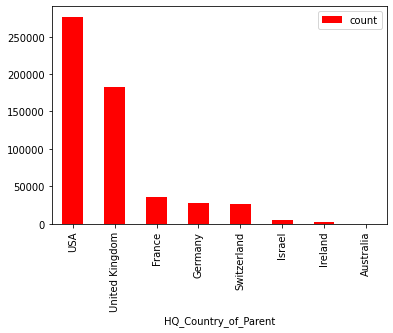

In [0]:
q7_result.toPandas().plot(kind = "bar", x="HQ_Country_of_Parent", y="count", colormap="hsv",)
plt.show()

In [0]:
q8 = group_order(q7,"Offense_Group")
display(q8)

Offense_Group,count
government-contracting-related offenses,199881
environment-related offenses,101953
healthcare-related offenses,75459
competition-related offenses,63470
safety-related offenses,60571
employment-related offenses,34440
consumer-protection-related offenses,12887
financial offenses,7179


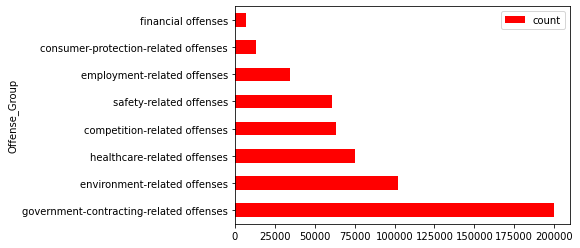

In [0]:
q8.toPandas().plot(kind = "barh", x="Offense_Group", y="count", colormap="hsv",)
plt.show()

FURTHER ANALYSIS OF STUDIES STATUS FOR YEAR 2021

In [0]:
q9 = completiondf21.select("Status","year").where(completiondf21.year == 2021)
q91=group_order(q9,"Status")
display(q91)

Status,count
Recruiting,12902
Completed,8571
"Active, not recruiting",6127
Not yet recruiting,2958
Unknown status,2289
Enrolling by invitation,918
Terminated,803
Withdrawn,753
Suspended,306


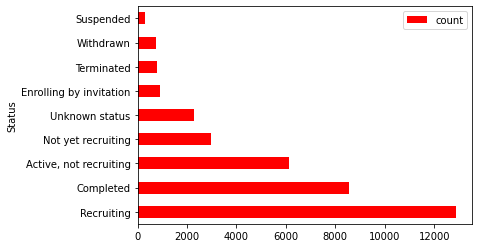

In [0]:
q91.toPandas().plot(kind = "barh", x="Status", y="count", colormap="hsv")
plt.show()

FURTHER ANALYSIS OF MOST REPEATED HEALTH CONDITIONS

In [0]:
q10 = group_order(joineddf1, "Conditions").limit(10)
display(q10)

Conditions,count
COVID-19,38969
Diabetes Mellitus,22160
Colorectal Neoplasms,21576
HIV Infections,19284
Prostatic Neoplasms,18396
Breast Neoplasms,17280
Lung Neoplasms,16794
Multiple Myeloma,16344
Lymphoma,16185
Obesity,13788


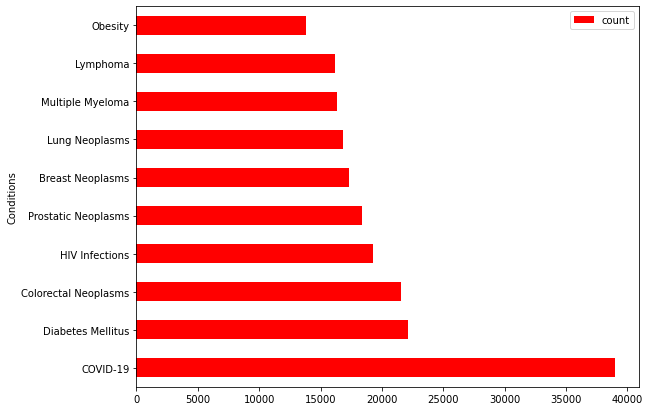

In [0]:
q10.toPandas().plot(kind = "barh", x="Conditions", y="count", colormap="hsv",figsize=(9, 7))
plt.show()